# 1 - Data acquisition

In [20]:
import numpy as np
import pandas as pd

In [21]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [22]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [23]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [24]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)


# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

presence = np.count_nonzero(cell_pop_M, axis = (0,1))
#print("Absolute presence for each species: \n", presence, '\n')

p_i = presence/(200)
#print("Relative presence for each species: \n", p_i, '\n')

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [51]:
# S+ - S-
S_present = np.count_nonzero(cell_pop_M, axis = (2)).flatten()

S_absent = S - S_present # broadcasting

# In each subplot there are more absent species than present
S_pm = S_present - S_absent

# constraint C_0 = < (S+ - S-)^2 >
C_0 = np.sum(np.power(S_pm,2))

## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = +\frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [27]:
m_i = 2*p_i - 1
eps = 10e-06 # a small regularization in order to avoid devergences
l_i = 0.5 * np.log(( 1 - m_i + eps)/( 1 + m_i + eps) )

## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $<(S_+ - S_-)^2>_{exp} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model} = C_0(\vec{\sigma})$ with coupled parameter $\lambda_0 = K/S$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)} - <(S_+ - S_-)^2>_{exp}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [28]:
import metropolis as M

In [30]:
# define the constraint functions
# s is thought as a configuration of S spins

# accetta matrice, somma su righe, restituisce vettore colonna
def K_constraint(s):
    return - np.power(s.sum(),2) 

#l_constraints = [lambda s : s[i] for i in range(S)]
l_constraints = []
# each lambda is the projection of the vector to its i-th coordinate
# accetta matrice, restituisce colonna i-esima
for i in range(S):
    l_constraints.append(lambda s, j=i: -s[j])
    
constraints_funcs = [K_constraint] + l_constraints
print(len(constraints_funcs))

300


In [31]:
# initialize the lagrangian parameters
l_0 = np.random.randn()
lagrange_multipliers = np.concatenate((np.array([l_0]), l_i))

exp_constraints = np.concatenate((np.array([C_0]), m_i))
print(len(exp_constraints))
print(len(lagrange_multipliers))

300
300


In [32]:
def gradient(model_configs, constraints_funcs, exp_constraints):
    # we feed to each constraint function an array of arrays, made by replicas of configurations of S spins
    N = len(model_configs)
    C = len(exp_constraints)
    #print("Number of constraints: ", C)
    #print("Shape of simulated configurations: ", model_configs.shape)
    #print("Number of constraints functions: ", len(constraints_funcs))
    model_constraints = np.zeros((N,C))
    for i in range(N):
        model_constraints[i] = np.array(list(map(lambda f: f(model_configs[i]), constraints_funcs)))
    #print(model_constraints[0].shape)
    # mean over the columns (replicas)
    mean_model_c = model_constraints.mean(axis = 0)
    #print(mean_model_c.shape)
    
    # returns the gradient (points in the direction of maximal growth)
    return mean_model_c - exp_constraints

In [33]:
help(M)

Help on module metropolis:

NAME
    metropolis

CLASSES
    builtins.object
        Metropolis
    
    class Metropolis(builtins.object)
     |  Metropolis(S, M=100, N=1000, max_acceptance=0.1)
     |  
     |  Metropolis algorithm for an Ising model with the Hamiltonian given by maximum entropy principle.
     |  
     |  Parameters
     |  ------------
     |  
     |  S              : number of spins of a configuration (size of the system)
     |  M              : number of configurations used to compute the running rate of acceptance (memory)
     |  N              : number of configurations to be sampled
     |  max_acceptance : acceptance rate under which starts the importance sampling (es. 0.10)
     |  
     |  Attributes
     |  ------------
     |  
     |  L_multipliers    : list or numpy array of m Lagrange multipliers 
     |  constraint_funcs : list of m functions of the spins of a configuration, to implement the max-ent constraints
     |  energy           : the Hamilt

In [45]:
import importlib
importlib.reload(M)

<module 'metropolis' from '/home/nicola/Nicola_unipd/QuartoAnno/TODO/StatMech Complex Systems/Exercise/Ex1/Forests/metropolis.py'>

In [46]:
# the learning rate
eta = 0.1

# and the number of iterations
max_iter = 10000

In [48]:
from tqdm import tqdm_notebook, tnrange
scores = np.zeros(max_iter)
for i in tnrange(max_iter):
    #instance of the class
    model = M.Metropolis(S, max_acceptance = 0.15)
    model.set_hamiltonian(lagrange_multipliers, constraints_funcs )
    model.sample(10)
    g = gradient(model.configs, constraints_funcs, exp_constraints)
    lagrange_multipliers = lagrange_multipliers - eta*g
    scores[i] = np.power(g,2).sum()

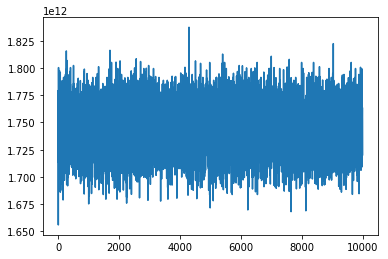

In [49]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(scores)
plt.show()